### Machine Learning Project on Github Issues
####  Github Issue Classification
+ Predicting if Github Issue is a Bug,Enhancement,Question or Docs,etc.

#### Data Source
+ https://tickettagger.blob.core.windows.net/datasets/dataset-labels-top3-30k-real.txt
+ https://gist.githubusercontent.com/rafaelkallis/6aa281b00d73d77fc843bd34f8184854/raw/8c10ebf2fd6f937f8
+ + https://github.com/dotnet/samples/tree/main/machine-learning/tutorials/GitHubIssueClassification/Data

#### Credits & Derivative Work
+ BEE, Yang Song and Oscar Chaparro
+ Tim Moser, David Steiger, Christian Birchler, Lara Fried, Sebastiano Panichella, Rafael Kallis
    


In [1]:
# Load EDA Pkgs
import pandas as pd
import numpy as np

# Load Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load ML Pkgs
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.dummy import DummyClassifier

In [4]:
### Data Collection
!wget https://tickettagger.blob.core.windows.net/datasets/dataset-labels-top3-30k-real.txt

--2023-10-06 18:14:01--  https://tickettagger.blob.core.windows.net/datasets/dataset-labels-top3-30k-real.txt
Resolving tickettagger.blob.core.windows.net (tickettagger.blob.core.windows.net)... 52.239.251.68
Connecting to tickettagger.blob.core.windows.net (tickettagger.blob.core.windows.net)|52.239.251.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22598414 (22M) [text/plain]
Saving to: ‘dataset-labels-top3-30k-real.txt’

dataset-labels-top3 100%[===================>]  21.55M  5.05MB/s    in 6.3s    

2023-10-06 18:14:08 (3.41 MB/s) - ‘dataset-labels-top3-30k-real.txt’ saved [22598414/22598414]



In [5]:
!ls

dataset-labels-top3-30k-real.txt  sample_data


In [6]:
# Load Dataset
df = pd.read_csv("dataset-labels-top3-30k-real.txt",header=None)

In [7]:
df.head()

,0
0,__label__enhancement Exception handling # Desc...
1,__label__enhancement Subpasses in MSL and HLSL...
2,__label__enhancement Collect new discovered no...
3,__label__enhancement Lock property : several p...
4,__label__bug Return default location type labe...


#### Text Cleaning
+ extract the labels from the text
    - Originally in FastText format
    - __label__enhancement|bug|question

In [8]:
df_new = df[0].str.split(r'(__label__enhancement)|(__label__bug)|(__label__question)',expand=True)

In [9]:
df_new.head()

,0,1,2,3,4
0,,__label__enhancement,None,None,Exception handling # Description The methods...
1,,__label__enhancement,None,None,Subpasses in MSL and HLSL Sorry for all the i...
2,,__label__enhancement,None,None,Collect new discovered nodes Collect new adde...
3,,__label__enhancement,None,None,Lock property : several properties at once
4,,None,__label__bug,None,Return default location type label if custom ...


In [10]:
enh_df = df_new[df_new[1] == '__label__enhancement'][[1,4]]

In [11]:
bug_df = df_new[df_new[2] == '__label__bug'][[2,4]]
question_df = df_new[df_new[3] == '__label__question'][[3,4]]

In [12]:
bug_df.head()

,2,4
4,__label__bug,Return default location type label if custom ...
6,__label__bug,[TW-417] JSON export has extra commas (on 2.1...
7,__label__bug,System.AccessViolationException: my program t...
8,__label__bug,Topic mining fails with UnicodeEncodeError ``...
10,__label__bug,Preflight and non-batching requests throw an ...


In [13]:
question_df.head()

,3,4
12,__label__question,Avoiding the default NotEmpty::IS_EMPTY valid...
30,__label__question,Is there a way to authenticate the video stre...
68,__label__question,"Disable rotation of the plugin Hi, I disable..."
112,__label__question,Question: Rule and Strategy over certain time...
124,__label__question,Is the .postcssrc file still necessary?


In [14]:
enh_df.columns = ['label','description']
bug_df.columns = ['label','description']
question_df.columns = ['label','description']

In [15]:
# Concat Dataframes
df = pd.concat([enh_df,bug_df,question_df])

In [16]:
df.head()

,label,description
0,__label__enhancement,Exception handling # Description The methods...
1,__label__enhancement,Subpasses in MSL and HLSL Sorry for all the i...
2,__label__enhancement,Collect new discovered nodes Collect new adde...
3,__label__enhancement,Lock property : several properties at once
5,__label__enhancement,Randomize: remove sliders


In [17]:
# Shape
df.shape

(30000, 2)

In [18]:
# Save Dataset
df.to_csv("github-issues-dataset-labels-top3-30k-real.csv")

In [19]:
df.head()

,label,description
0,__label__enhancement,Exception handling # Description The methods...
1,__label__enhancement,Subpasses in MSL and HLSL Sorry for all the i...
2,__label__enhancement,Collect new discovered nodes Collect new adde...
3,__label__enhancement,Lock property : several properties at once
5,__label__enhancement,Randomize: remove sliders


In [20]:
df['label'] = df['label'].str.replace('__label__','')

In [21]:
df.head()

,label,description
0,enhancement,Exception handling # Description The methods...
1,enhancement,Subpasses in MSL and HLSL Sorry for all the i...
2,enhancement,Collect new discovered nodes Collect new adde...
3,enhancement,Lock property : several properties at once
5,enhancement,Randomize: remove sliders


In [22]:
# Save Dataset
df.to_csv("github-issues-dataset-labels.csv")

### Class Distribution Analysis

In [23]:
df['label'].value_counts()

bug            15286
enhancement    12193
question        2521
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

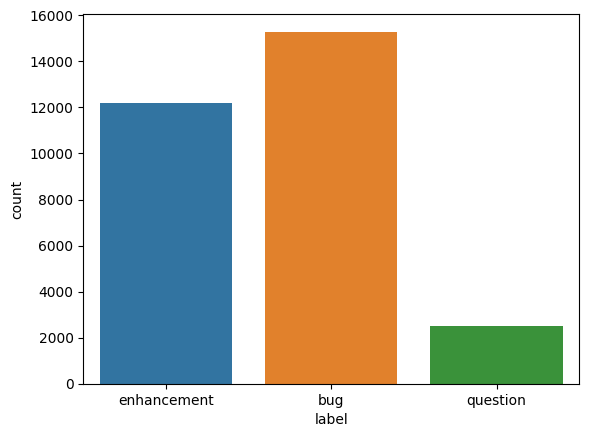

In [24]:
sns.countplot(x='label',data=df)

### Text Cleaning using NeatText
+ pip install neattext

In [25]:
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.3 MB/s eta 0:00:00


In [26]:
df.iloc[0].description

' Exception handling # Description  The methods that use try/catch blocks are quite limiting. Simply throw the exceptions and let users handle them. New idea: an exception handler wrapper class?    # Technical Information  | Information | Value |  |--|--|  | Operating System | Irrelevant |  |Architecture | Irrelevant |  | JavaEssentials Version| 1.2.2 Beta 1 |  '

In [27]:
import neattext.functions as nfx

In [28]:
df['description_clean'] = df['description'].apply(lambda x: nfx.remove_stopwords(str(x).lower()))

In [29]:
df.iloc[0].description_clean

'exception handling # description methods use try/catch blocks limiting. simply throw exceptions let users handle them. new idea: exception handler wrapper class? # technical information | information | value | |--|--| | operating system | irrelevant | |architecture | irrelevant | | javaessentials version| 1.2.2 beta 1 |'

### Building our Model using Pipeline Approach

In [30]:
# Make a Pipeline
pipe_base = Pipeline(steps=[('cv',CountVectorizer()),('dummy',DummyClassifier())])
pipe_nb = Pipeline(steps=[('cv',CountVectorizer()),('nb',MultinomialNB())])
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])
pipe_dt = Pipeline(steps=[('cv',CountVectorizer()),('dt',DecisionTreeClassifier())])

In [31]:
# Features & Labels
Xfeatures = df['description_clean']
ylabels = df['label']

In [32]:
#Split Dataset
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=42)

In [33]:
# Base Model: accuracy
pipe_base.fit(x_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dummy', DummyClassifier())])

In [34]:
# Accuracy
pipe_base.score(x_test,y_test)

0.5091111111111111

In [35]:
# Build our Actual Models
pipe_nb.fit(x_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('nb', MultinomialNB())])

In [36]:
# Accuracy
pipe_nb.score(x_test,y_test)

0.6584444444444445

In [ ]:
#### Evaluate

In [37]:
y_pred = pipe_nb.predict(x_test)

In [38]:
# Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         bug       0.76      0.62      0.68      4582
 enhancement       0.59      0.81      0.69      3679
    question       0.39      0.10      0.16       739

    accuracy                           0.66      9000
   macro avg       0.58      0.51      0.51      9000
weighted avg       0.66      0.66      0.64      9000



In [39]:
# Build our Actual Models
pipe_dt.fit(x_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dt', DecisionTreeClassifier())])

In [ ]:
# Accuracy

In [40]:
pipe_dt.score(x_test,y_test)

0.6687777777777778

In [41]:
y_pred_dt = pipe_dt.predict(x_test)

In [42]:
# Report
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

         bug       0.73      0.75      0.74      4582
 enhancement       0.69      0.65      0.67      3679
    question       0.23      0.25      0.24       739

    accuracy                           0.67      9000
   macro avg       0.55      0.55      0.55      9000
weighted avg       0.67      0.67      0.67      9000



In [43]:
# Build our Actual Models
pipe_lr.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [ ]:
# Accuracy

In [44]:
### Saving Model
import joblib

In [45]:
model_file = open("pipe_nb_cv_gh_issue_classifier_27_nov_2021.pkl","wb")
joblib.dump(pipe_nb,model_file)
model_file.close()

In [46]:
model_file = open("pipe_dt_cv_gh_issue_classifier_27_nov_2021.pkl","wb")
joblib.dump(pipe_dt,model_file)
model_file.close()

### Make Individual Prediction
+ ex1: bug
+ ex2: enh

In [47]:
ex1 = "Keras load_img is not working if i display any image on the top of the page "
ex2 = "Feature request: Slider: negative space and histograms"

In [48]:
# Using NB
pipe_nb.predict([ex1])

array(['enhancement'], dtype='<U11')

In [49]:
# Using NB
print(pipe_nb.classes_)
pipe_nb.predict_proba([ex1])

['bug' 'enhancement' 'question']


array([[0.35455005, 0.62288926, 0.02256069]])

In [50]:
# Using NB
pipe_nb.predict([ex2])

array(['enhancement'], dtype='<U11')

In [51]:
# Using DT
pipe_dt.predict([ex1])

array(['bug'], dtype=object)

In [52]:
# Using DT
print(pipe_dt.classes_)
pipe_dt.predict_proba([ex1])

['bug' 'enhancement' 'question']


array([[1., 0., 0.]])

In [53]:
# Using DT
pipe_dt.predict([ex2])

array(['enhancement'], dtype=object)

#### Narrative
+ It appears that the DecisitionTree Classifier Does a little bit better than the Naive Bayes Model
